In [20]:
# multi headed multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

from query2 import *
from Func_Paper1 import *

In [21]:
df = data1()

df.index = df['datetime']
df.index = df.index.astype('datetime64[ns]')
df.sort_index(inplace=True)
df.dropna(inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])

df.drop(('datetime'), axis=1, inplace=True)

print("shape ", df.shape)

shape  (4409, 32)


In [22]:
from sklearn.preprocessing import MinMaxScaler
y_scaler = MinMaxScaler()
y_scaler.fit(df[['fore24']])

X_scaler = MinMaxScaler()

df[['tail24', 'tail24_avg', 'evap', 'infl', 'losses',
       'rel1', 'rel2', 'rel3', 'rel_tol', 'engr1', 'engr2', 'engr3', 'cond1',
       'cond2', 'cond3', 'str1', 'str2', 'str3', 'run_g1', 'run_g2', 'run_g3',
       'run_c1', 'run_c2', 'run_c3', 'spillway', 'irr', 'camp', 'demand',
       'derate', 'outage', 'stor','fore24']] = X_scaler.fit_transform(df)

In [23]:
df.head(1)

,tail24,tail24_avg,evap,infl,losses,rel1,rel2,rel3,rel_tol,engr1,...,run_c2,run_c3,spillway,irr,camp,demand,derate,outage,stor,fore24
datetime,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0.162554,0.0,0.546712,0.0,0.0,0.0,0.0,0.0,0.137414,0.0,...,0.0,0.0,0.0,0.0,0.000066,0.0,0.0,0.0,0.748846,0.794376


In [44]:
def split_dataset(data):

    train, test = data[:-89], data[:-89]
    print('train', train.shape)
    print('test', test.shape)

    train = array(split(train, len(train)/180))
    test = array(split(test, len(test)/180))
    return train, test

In [45]:
4320%180

0

In [46]:
train, test = split_dataset(df.values)

train (4320, 32)
test (4320, 32)


In [47]:
print('train', train.shape)
print('test', test.shape)

train (24, 180, 32)
test (24, 180, 32)


In [48]:
n_input = 14

In [50]:
def to_supervised(train, n_input, n_out=180):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2])) #()
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)): #len(data) = 1113
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 31])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [51]:
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 100, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # create a channel for each variable
    in_layers, out_layers = list(), list()
    for i in range(n_features):
        inputs = Input(shape=(n_timesteps,1))
        conv1 = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
        conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
        pool1 = MaxPooling1D(pool_size=2)(conv2)
        flat = Flatten()(pool1)
        # store layers
        in_layers.append(inputs)
        out_layers.append(flat)
    # merge heads
    merged = concatenate(out_layers)
    # interpretation
    dense1 = Dense(200, activation='relu')(merged)
    dense2 = Dense(100, activation='relu')(dense1)
    outputs = Dense(n_outputs)(dense2)
    model = Model(inputs=in_layers, outputs=outputs)
    # compile model
    model.compile(loss='mse', optimizer='adam')
    
    
    save_path = 'models/'
    filepath=save_path+"weights{epoch:02d}.hdf5"
    checkpointer = ModelCheckpoint(monitor='val_loss', filepath=filepath, verbose=1, save_best_only=True)
        
    # fit network
    input_data = [train_x[:,:,i].reshape((train_x.shape[0],n_timesteps,1)) for i in range(n_features)]
    history = model.fit(input_data, train_y, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=verbose,callbacks=[checkpointer])
    return model

In [52]:
model = build_model(train, n_input)

Train on 3301 samples, validate on 826 samples
Epoch 1/100
3301/3301 [==============================] - 24s 7ms/step - loss: 0.0497 - val_loss: 0.0437

Epoch 00001: val_loss improved from inf to 0.04367, saving model to models/weights01.hdf5
Epoch 2/100
3301/3301 [==============================] - 13s 4ms/step - loss: 0.0160 - val_loss: 0.0281

Epoch 00002: val_loss improved from 0.04367 to 0.02814, saving model to models/weights02.hdf5
Epoch 3/100
3301/3301 [==============================] - 13s 4ms/step - loss: 0.0130 - val_loss: 0.0277

Epoch 00003: val_loss improved from 0.02814 to 0.02770, saving model to models/weights03.hdf5
Epoch 4/100
3301/3301 [==============================] - 13s 4ms/step - loss: 0.0113 - val_loss: 0.0293

Epoch 00004: val_loss did not improve from 0.02770
Epoch 5/100
3301/3301 [==============================] - 13s 4ms/step - loss: 0.0096 - val_loss: 0.0307

Epoch 00005: val_loss did not improve from 0.02770
Epoch 6/100
3301/3301 [=========================

3301/3301 [==============================] - 13s 4ms/step - loss: 7.9524e-04 - val_loss: 0.0444

Epoch 00052: val_loss did not improve from 0.02770
Epoch 53/100
3301/3301 [==============================] - 13s 4ms/step - loss: 8.6729e-04 - val_loss: 0.0415

Epoch 00053: val_loss did not improve from 0.02770
Epoch 54/100
3301/3301 [==============================] - 13s 4ms/step - loss: 7.6708e-04 - val_loss: 0.0417

Epoch 00054: val_loss did not improve from 0.02770
Epoch 55/100
3301/3301 [==============================] - 14s 4ms/step - loss: 8.2430e-04 - val_loss: 0.0392

Epoch 00055: val_loss did not improve from 0.02770
Epoch 56/100
3301/3301 [==============================] - 13s 4ms/step - loss: 8.1251e-04 - val_loss: 0.0425

Epoch 00056: val_loss did not improve from 0.02770
Epoch 57/100
3301/3301 [==============================] - 13s 4ms/step - loss: 8.1330e-04 - val_loss: 0.0382

Epoch 00057: val_loss did not improve from 0.02770
Epoch 58/100
3301/3301 [=======================

In [53]:
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into n input arrays
    input_x = [input_x[:,i].reshape((1,input_x.shape[0],1)) for i in range(input_x.shape[1])]
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [54]:
#เป็น list ที่สมาชิกแต่ละตัวเป็น samples (windows, n-feature)
history = [x for x in train]

In [55]:
print(len(history))
print(type(history))
print((array(history).shape))
print(type(array(history)))

24
<class 'list'>
(24, 180, 32)
<class 'numpy.ndarray'>


In [56]:
predictions = list()
for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = array(predictions)

In [57]:
score, scores = evaluate_forecasts(test[:, :, 31], predictions)

In [58]:
summarize_scores('cnn', score, scores)

cnn: [0.104] 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1


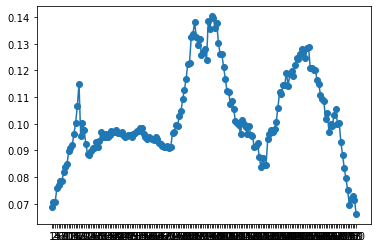

In [63]:
days = ['1','2','3','4','5','6','7','8','9','10',
        '11','12','13','14','15','16','17','18','19','20',
        '21','22','23','24','25','26','27','28','29','30',
        '31','32','33','34','35','36','37','38','39','40',
        '41','42','43','44','45','46','47','48','49','50',
        '51','52','53','54','55','56','57','58','59','60',
        '61','62','63','64','65','66','67','68','69','70',
        '71','72','73','74','75','76','77','78','79','80',
        '81','82','83','84','85','86','87','88','89','90',
        '91','92','93','94','95','96','97','98','99','100',
        '101','102','103','104','105','106','107','108','109','110',
        '111','112','113','114','115','116','117','118','119','120',
        '121','122','123','124','125','126','127','128','129','130',
        '131','132','133','134','135','136','137','138','139','140',
        '141','142','143','144','145','146','147','148','149','150',
        '151','152','153','154','155','156','157','158','159','160',
        '161','162','163','164','165','166','167','168','169','170',
        '171','172','173','174','175','176','177','178','179','180']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()

In [64]:
C = pd.DataFrame(test[:, :, 31])
C.columns = ['A1','A2','A3','A4','AA5','A6','A7','A8','A9','A10',
        'A11','A12','A13','A14','A15','A16','A17','A18','A19','A20',
        'A21','A22','A23','A24','A25','A26','A27','A28','A29','A30',
        'A31','A32','A33','A34','A35','A36','A37','A38','A39','A40',
        'A41','A42','A43','A44','A45','A46','A47','A48','A49','A50',
        'A51','A52','A53','A54','A55','A56','A57','A58','A59','A60',
        'A61','A62','A63','A64','A65','A66','A67','A68','A69','A70',
        'A71','A72','A73','A74','A75','A76','A77','A78','A79','A80',
        'A81','A82','A83','A84','A85','A86','A87','A88','A89','A90',
        'A91','A92','A93','A94','A95','A96','A97','A98','A99','A100',
        'A101','A102','A103','A104','A105','A106','A107','A108','A109','A110',
        'A111','A112','A113','A114','A115','A116','A117','A118','A119','A120',
        'A121','A122','A123','A124','A125','A126','A127','A128','A129','A130',
        'A131','A132','A133','A134','A135','A136','A137','A138','A139','A140',
        'A141','A142','A143','A144','A145','A146','A147','A148','A149','A150',
        'A151','A152','A153','A154','A155','A156','A157','A158','A159','A160',
        'A161','A162','A163','A164','A165','A166','A167','A168','A169','A170',
        'A171','A172','A173','A174','A175','A176','A177','A178','A179','A180']
D = pd.DataFrame(predictions)
D.columns = ['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10',
        'P11','P12','P13','P14','P15','P16','P17','P18','P19','P20',
        'P21','P22','P23','P24','P25','P26','P27','P28','P29','P30',
        'P31','P32','P33','P34','P35','P36','P37','P38','P39','P40',
        'P41','P42','P43','P44','P45','P46','P47','P48','P49','P50',
        'P51','P52','P53','P54','P55','P56','P57','P58','P59','P60',
        'P61','P62','P63','P64','P65','P66','P67','P68','P69','P70',
        'P71','P72','P73','P74','P75','P76','P77','P78','P79','P80',
        'P81','P82','P83','P84','P85','P86','P87','P88','P89','P90',
        'P91','P92','P93','P94','P95','P96','P97','P98','P99','P100',
        'P101','P102','P103','P104','P105','P106','P107','P108','P109','P110',
        'P111','P112','P113','P114','P115','P116','P117','P118','P119','P120',
        'P121','P122','P123','P124','P125','P126','P127','P128','P129','P130',
        'P131','P132','P133','P134','P135','P136','P137','P138','P139','P140',
        'P141','P142','P143','P144','P145','P146','P147','P148','P149','P150',
        'P151','P152','P153','P154','P155','P156','P157','P158','P159','P160',
        'P161','P162','P163','P164','P165','P166','P167','P168','P169','P170',
        'P171','P172','P173','P174','P175','P176','P177','P178','P179','P180']

In [65]:
C.to_csv('real.csv')

In [66]:
D.to_csv('predictions.csv')